## Sentiment Analysis on All Data

In [ ]:
!pip install nltk matplotlib seaborn wordcloud langdetect googletrans==4.0.0-rc1 vaderSentiment

In [3]:
import pandas as pd
import re

In [4]:
movistar = pd.read_csv("./reviews/MX/trustpilot_movistar_reviews.csv")
movistar["operator"] = "Movistar"
movistar["country"] = "Mexico"

telcel = pd.read_csv("./reviews/MX/trustpilot_telcel_reviews.csv")
telcel["operator"] = "TelCell"
telcel["country"] = "Mexico"

ais = pd.read_csv("./reviews/THA/trustpilot_ais_reviews.csv")
ais["operator"] = "AIS"
ais["country"] = "Thailand"

dtac = pd.read_csv("./reviews/THA/trustpilot_dtac_reviews.csv")
dtac["operator"] = "DTAC"
dtac["country"] = "Thailand"

truemoveh = pd.read_csv("./reviews/THA/trustpilot_truemoveh_reviews.csv")
truemoveh["operator"] = "TrueMove H"
truemoveh["country"] = "Thailand"

cellc = pd.read_csv("./reviews/SA/hellopeter_cellc_reviews.csv")
cellc["operator"] = "Cell C"
cellc["country"] = "South Africa"

mtn = pd.read_csv("./reviews/SA/hellopeter_mtn_reviews.csv")
mtn["operator"] = "MTN"
mtn["country"] = "South Africa"

vodacom = pd.read_csv("./reviews/SA/hellopeter_vodacom_reviews_scroll.csv")
vodacom["operator"] = "Vodacom"
vodacom["country"] = "South Africa"

sa_reddit = pd.read_csv("./reviews/SA/reddit_comments.csv")
sa_reddit["operator"] = "Reddit"
sa_reddit["country"] = "South Africa"

In [5]:
df = pd.concat([movistar, telcel, ais, dtac, truemoveh, cellc, mtn, vodacom, sa_reddit], ignore_index=True)

In [6]:
df.head(2)

,username,review,operator,country,date,author,comment
0,PJ,"Slow, specially in Sumer, to the point of bein...",Movistar,Mexico,NaN,NaN,NaN
1,PJ Jones,Shocking service. Out of contract and monthly ...,Movistar,Mexico,NaN,NaN,NaN


In [7]:
df = df.drop(columns=[col for col in ["date", "author", "comment"] if col in df.columns])

In [8]:
df.head(2)

,username,review,operator,country
0,PJ,"Slow, specially in Sumer, to the point of bein...",Movistar,Mexico
1,PJ Jones,Shocking service. Out of contract and monthly ...,Movistar,Mexico


In [9]:
df.to_csv("./reviews/all_reviews.csv", index=False)

In [10]:
# Clean up any missing reviews
df = df.dropna(subset=["review"])

In [11]:
# lowercase, remove non-alphabetic characters
df["clean_review"] = df["review"].str.lower().apply(lambda x: re.sub(r"[^a-z\s]", "", x))

In [12]:
from langdetect import detect
from googletrans import Translator

In [13]:
df.dropna(subset=["clean_review"], inplace=True)

In [14]:
translator = Translator()

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["language"] = df["clean_review"].apply(detect_language)

In [15]:
# Translate only non-English
def translate_if_needed(row):
    if row["language"] != "en":
        try:
            return translator.translate(row["clean_review"], dest='en').text
        except:
            return row["clean_review"]
    else:
        return row["clean_review"]

df["translated_review"] = df.apply(translate_if_needed, axis=1)

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [17]:
nltk.download("vader_lexicon")

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\deyna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
# Run sentiment analysis
df["sentiment"] = df["translated_review"].apply(lambda x: sid.polarity_scores(x)["compound"])

# Label sentiment for easier interpretation
def label_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment"].apply(label_sentiment)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

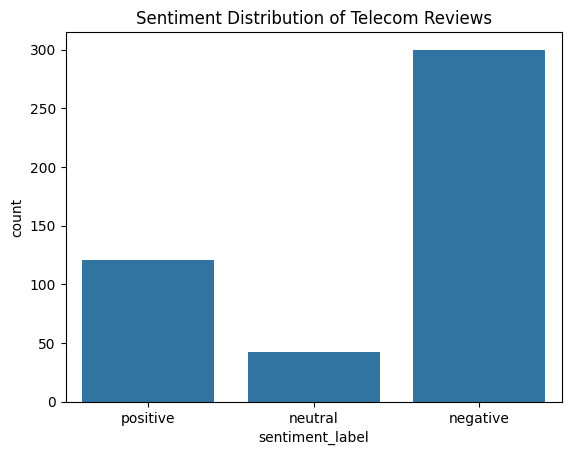

In [20]:
sns.countplot(data=df, x="sentiment_label", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution of Telecom Reviews")
plt.show()

In [21]:
from wordcloud import WordCloud

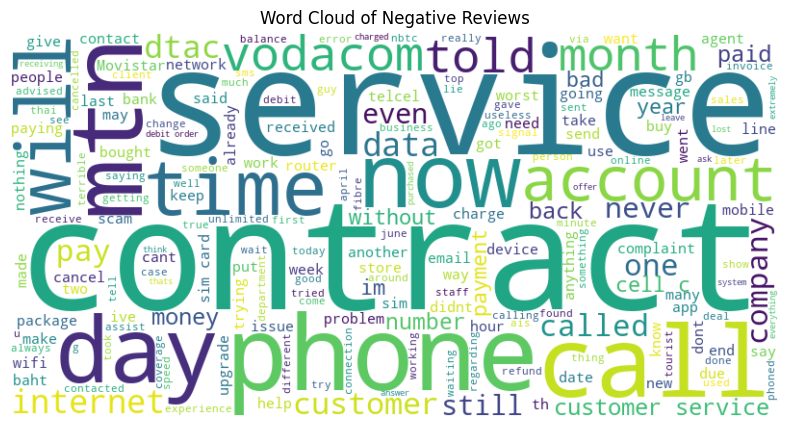

In [22]:
text = " ".join(df[df["sentiment_label"] == "negative"]["translated_review"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Reviews")
plt.show()

In [25]:
# # Summary stats
# summary = df.groupby("sentiment_label").agg(
#     count=("sentiment", "count"),
#     avg_score=("sentiment", "mean")
# ).reset_index()

# print(summary)

In [23]:
country_summary = df.groupby("country").agg(
    review_count=("review", "count"),
    avg_sentiment=("sentiment", "mean"),
    positive_pct=("sentiment_label", lambda x: (x == "positive").mean() * 100),
    negative_pct=("sentiment_label", lambda x: (x == "negative").mean() * 100),
    neutral_pct=("sentiment_label", lambda x: (x == "neutral").mean() * 100)
).reset_index()

country_summary

,country,review_count,avg_sentiment,positive_pct,negative_pct,neutral_pct
0,Mexico,97,-0.499536,9.278351,81.443299,9.278351
1,South Africa,275,-0.168176,34.909091,57.818182,7.272727
2,Thailand,91,-0.341027,17.582418,68.131868,14.285714


In [24]:
country_summary.to_csv("./reviews/sentiment_by_country.csv", index=False)

In [25]:
# Grouped sentiment summary by operator (across countries)
operator_summary = df.groupby(["country", "operator"]).agg(
    review_count=("review", "count"),
    avg_sentiment=("sentiment", "mean"),
    positive_pct=("sentiment_label", lambda x: (x == "positive").mean() * 100),
    negative_pct=("sentiment_label", lambda x: (x == "negative").mean() * 100),
    neutral_pct=("sentiment_label", lambda x: (x == "neutral").mean() * 100)
).reset_index()


In [26]:
operator_summary

,country,operator,review_count,avg_sentiment,positive_pct,negative_pct,neutral_pct
0,Mexico,Movistar,56,-0.486846,8.928571,83.928571,7.142857
1,Mexico,TelCell,41,-0.516868,9.756098,78.048780,12.195122
2,South Africa,Cell C,66,-0.157598,42.424242,53.030303,4.545455
3,South Africa,MTN,121,-0.144860,34.710744,57.024793,8.264463
4,South Africa,Vodacom,88,-0.208169,29.545455,62.500000,7.954545
5,Thailand,AIS,19,-0.163826,26.315789,47.368421,26.315789
6,Thailand,DTAC,57,-0.387551,14.035088,73.684211,12.280702
7,Thailand,TrueMove H,15,-0.388693,20.000000,73.333333,6.666667


In [27]:
operator_summary.to_csv("./reviews/operator_summary.csv", index=False)